In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# fastai imports
from fastai.vision import *

# import path to use path objects instead of strings
from pathlib import Path

In [4]:
! pwd

/home/titus/fastai/SATAI


In [5]:
path = Path('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000')
path_part1 = path/'HAM10000_images_part_1'
path_part2 = path/'HAM10000_images_part_2'
data_path = path/"HAM10000_metadata.csv"

In [6]:
help(get_image_files)

Help on function get_image_files in module fastai.vision.data:

get_image_files(c: Union[pathlib.Path, str], check_ext: bool = True, recurse=False) -> Collection[pathlib.Path]
    Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`.



#### Get images

Obtaining images from path 1

In [7]:
fnames_1 = get_image_files(path_part1)
fnames_1[:3]

[PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026902.jpg'),
 PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025846.jpg'),
 PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025998.jpg')]

Obtaining images from path 2

In [8]:
fnames_2 = get_image_files(path_part2)
fnames_2[:3]

[PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0030678.jpg'),
 PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033076.jpg'),
 PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0032350.jpg')]

Joining images

In [9]:
fnames = fnames_1 + fnames_2

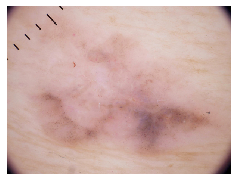

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(4,4))

In [11]:
df = pd.read_csv(data_path)
df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


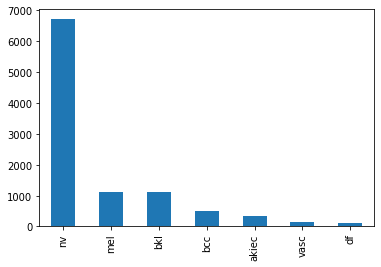

In [12]:
df['dx'].value_counts().plot(kind = 'bar')

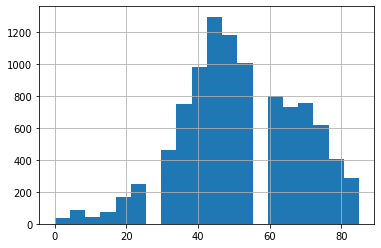

In [13]:
df['age'].hist(bins = 20)

We define the batch size and the size of the images

In [14]:
#bs = 64
bs = 32

size = 224

#### Transform

In [15]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [16]:
doc(ImageDataBunch)

In [17]:
data = ImageDataBunch.from_csv(path, 
                               folder='images',
                               csv_labels='HAM10000_metadata.csv', 
                               suffix='.jpg', 
                               fn_col=1, 
                               label_col=2, 
                               ds_tfms=tfms, 
                               valid_pct = 0.2,
                               size=size, 
                               bs=bs)
print('Transforms = ', len(tfms))
# Save the DataBunch in case the training goes south... so you won't have to regenerate it..
# Remember: this DataBunch is tied to the batch size you selected. 
data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')
# Show the statistics of the Bunch...
print(data.classes)
data

Transforms =  2
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


ImageDataBunch;

Train: LabelList (8012 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bkl,bkl,bkl,bkl,bkl
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bkl,nv,nv,mel,nv
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000;

Test: None

In [18]:
data = ImageDataBunch.from_df(
    path = path/'images',    # path to images folder
    df = df,                 # dataframe
    suffix = '.jpg',         # image extension
    fn_col = 1,              # image_id column as name
    label_col = 2,           # dx as label
    ds_tfms=tfms,            # data augmentation
    size = size,             # image size
    bs = bs                  # batch size
)
data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')
# Show the statistics of the Bunch...
print(data.classes)
data

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


ImageDataBunch;

Train: LabelList (8012 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bkl,bkl,bkl,bkl,bkl
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/images;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
nv,mel,nv,nv,bcc
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/images;

Test: None

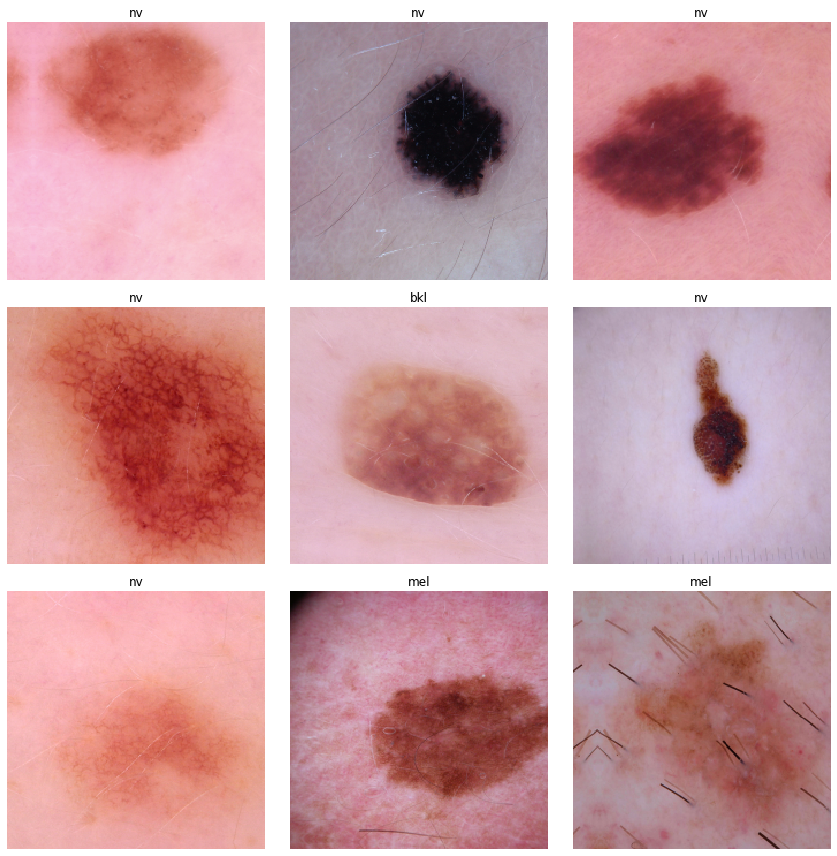

In [19]:
data.show_batch(rows=3)


In [20]:
! /usr/bin/nvidia-smi

Mon Dec  2 23:08:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P2    39W /  N/A |   1245MiB /  7982MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [21]:
data.normalize(imagenet_stats)  

ImageDataBunch;

Train: LabelList (8012 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bkl,bkl,bkl,bkl,bkl
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/images;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
nv,mel,nv,nv,bcc
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/images;

Test: None

In [22]:
learner = cnn_learner(
    data, 
    models.resnet34, 
    metrics=[error_rate, Recall(), Precision(), FBeta(), MatthewsCorreff()], 
    path=path/'models'
)

In [23]:
doc(cnn_learner)

In [24]:
learner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [25]:
defaults.device = torch.device('cuda')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


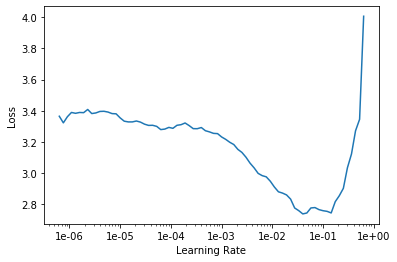

In [26]:
learner.lr_find()
learner.recorder.plot()

In [27]:

learner.fit_one_cycle(8, max_lr=slice(2e-3, 1e-2))

epoch,train_loss,valid_loss,error_rate,recall,precision,f_beta,matthews_correff,time
0,1.086183,0.773970,0.263105,0.546921,0.572065,0.549617,0.509628,01:01
1,0.819493,0.796902,0.249626,0.494503,nan,0.000000,0.523525,01:01
2,0.682120,0.615726,0.236146,0.509419,0.648251,0.532215,0.538494,01:00
3,0.586106,0.566261,0.215177,0.584171,0.728335,0.608250,0.613606,00:59
4,0.528509,0.502231,0.173739,0.616081,0.806337,0.646594,0.670275,01:00
5,0.464482,0.468031,0.169745,0.668580,0.814028,0.693358,0.678863,00:59
6,0.428020,0.436550,0.155267,0.686502,0.827525,0.710726,0.704739,01:00
7,0.420558,0.429635,0.156266,0.703122,0.810001,0.722180,0.705075,00:59


/home/titus/.local/lib/python3.7/site-packages/fastai/metrics.py:189: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [32]:
learner.save('stage-1-rn34', return_path=True)

PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/models/models/stage-1-rn34.pth')

In [29]:
doc(learner.export)

In [31]:
learner.export(file = Path('/home/titus/fastai/SATAI/trained_model_FAI.pkl'))

In [34]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 6.31E-08


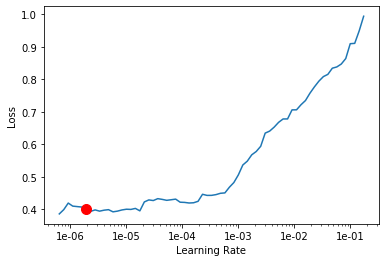

In [35]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [41]:
lr = 2e-3
lr_frozen = 3e-3

In [42]:
learner.fit_one_cycle(5, slice(lr,lr_frozen/5))

epoch,train_loss,valid_loss,error_rate,recall,precision,f_beta,matthews_correff,time
0,0.824916,0.919898,0.307039,0.283515,nan,0.281042,0.374920,01:03
1,0.803606,0.831278,0.298053,0.478967,nan,0.000000,0.456474,01:02
2,0.739109,0.702409,0.273090,0.457226,nan,0.000000,0.470600,01:01
3,0.637736,0.619551,0.235147,0.536492,0.671555,0.558976,0.536927,01:01
4,0.625896,0.597872,0.226161,0.556585,0.707959,0.581450,0.560225,01:00


In [43]:
learner.save('stage-2')

In [44]:
learner.export(file = Path('/home/titus/fastai/SATAI/trained_model_unfrozen_FAI.pkl'))

In [45]:
interp = ClassificationInterpretation.from_learner(learner)

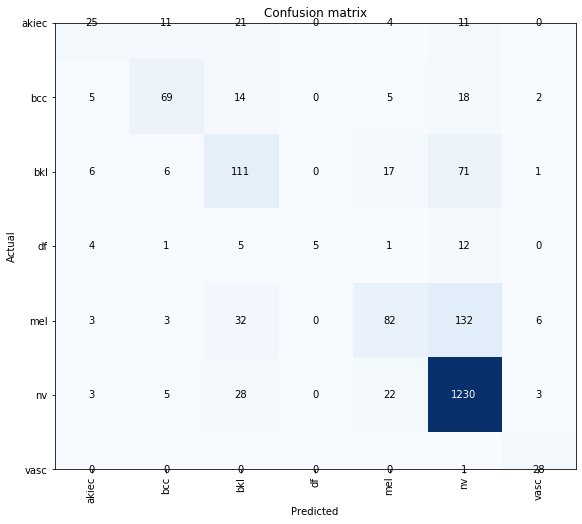

In [47]:
interp.plot_confusion_matrix(figsize=(8,8))

In [48]:
interp.most_confused()

[('mel', 'nv', 132),
 ('bkl', 'nv', 71),
 ('mel', 'bkl', 32),
 ('nv', 'bkl', 28),
 ('nv', 'mel', 22),
 ('akiec', 'bkl', 21),
 ('bcc', 'nv', 18),
 ('bkl', 'mel', 17),
 ('bcc', 'bkl', 14),
 ('df', 'nv', 12),
 ('akiec', 'bcc', 11),
 ('akiec', 'nv', 11),
 ('bkl', 'akiec', 6),
 ('bkl', 'bcc', 6),
 ('mel', 'vasc', 6),
 ('bcc', 'akiec', 5),
 ('bcc', 'mel', 5),
 ('df', 'bkl', 5),
 ('nv', 'bcc', 5),
 ('akiec', 'mel', 4),
 ('df', 'akiec', 4),
 ('mel', 'akiec', 3),
 ('mel', 'bcc', 3),
 ('nv', 'akiec', 3),
 ('nv', 'vasc', 3),
 ('bcc', 'vasc', 2),
 ('bkl', 'vasc', 1),
 ('df', 'bcc', 1),
 ('df', 'mel', 1),
 ('vasc', 'nv', 1)]